In [61]:
import pandas as pd
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 
import warnings
import numpy as np
import sqlite3
import json
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
import joblib
from joblib import dump, load
from pathlib import Path
import datetime

%matplotlib inline
warnings.filterwarnings('ignore')

In [62]:
f = Path("csvs/data.csv")
if not f.is_file():
    tmp = pd.read_csv('csvs/respuestas_encuestas.csv')
    data = tmp.astype(str).pivot_table(index="id_encuesta",columns="id_pregunta",values="respuesta",aggfunc=','.join)
    data.index = data.index.astype(int) #use astype to convert to int
    data.index.name = 'id'
    respuestas = pd.read_csv('csvs/encuestas.csv').set_index('id')
    data = data.join(respuestas, how='inner')
    data.rename(columns={'candidato': 'candidatoId'}, inplace=True)
    data.reset_index(level=0, inplace=True)
    data.to_csv(path_or_buf='csvs/data.csv')    
else:
    data = pd.read_csv('csvs/data.csv')
    data.drop(columns=['Unnamed: 0'],inplace=True)
df = data
df.head()

,id,1,10,11,12,13,14,15,16,17,...,26,3,4,5,6,7,8,9,candidatoId,fecha
0,100,2,4,2,2,5,3,4,4,5,...,4,3,4,2,5,4,4,4,20,2019-02-07T18:17:25.611401
1,1000,2,3,3,3,4,3,4,3,5,...,4,2,3,3,5,5,4,4,9,2019-02-19T16:54:35.074392
2,100001,4,5,5,5,5,1,1,3,1,...,4,5,1,5,1,1,4,5,3,2019-02-21T15:56:04.223884
3,100006,4,1,5,1,5,5,5,4,5,...,5,5,5,5,5,5,2,4,4,2019-02-21T15:56:21.236512
4,100011,5,5,2,5,4,5,4,5,5,...,5,3,4,1,5,4,4,4,9,2019-02-21T15:56:46.090402


In [47]:
cand_data = json.loads(open('predictor_pol/candidatos.json','r').read())

In [48]:
def get_party(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return p['party']
    return 'n/a'

def get_name(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return c['name']
    return 'n/a'

In [49]:
df['partido'] = df.candidatoId.apply(get_party)
df['nombre'] = df.candidatoId.apply(get_name)

In [50]:
df.head(1)

,Unnamed: 0,id,1,10,11,12,13,14,15,16,...,4,5,6,7,8,9,candidatoId,fecha,partido,nombre
0,0,100,2,4,2,2,5,3,4,4,...,4,2,5,4,4,4,20,2019-02-07T18:17:25.611401,Partido de la Gente,Edgardo Novick


# Análisis exploratorio

In [51]:
print("cantidad de registros: {}".format(len(df)))

cantidad de registros: 30196


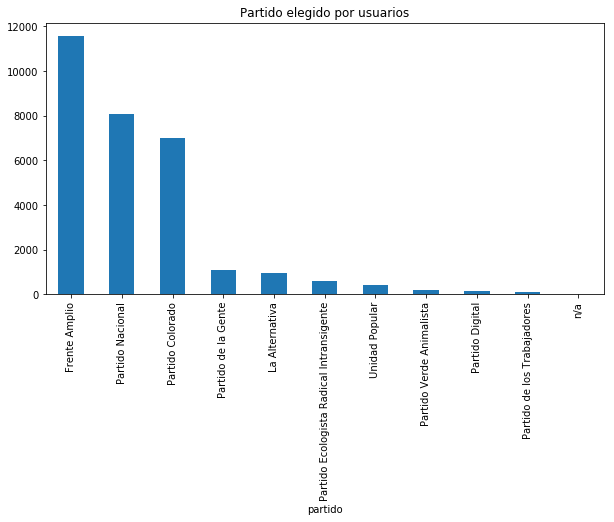

In [52]:
plt.rcParams['figure.figsize'] = [10, 5]
df.groupby('partido').size().sort_values(ascending=False).plot.bar(title='Partido elegido por usuarios')

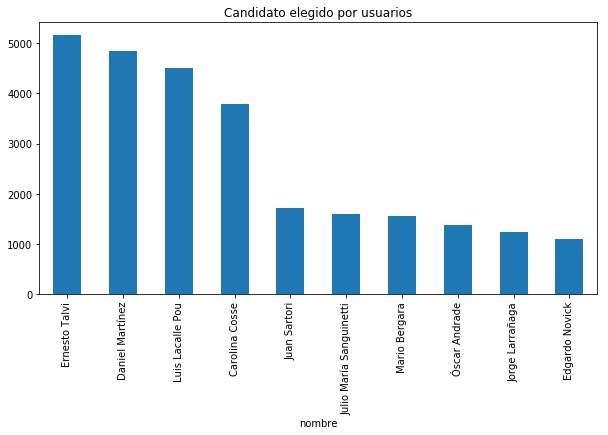

In [53]:
df.groupby('nombre').size().sort_values(ascending=False).head(10).plot.bar(title='Candidato elegido por usuarios')

In [54]:
by_day = pd.read_csv('csvs/encuestas_por_dia.csv')
by_day = by_day.sort_values(by='dia',ascending=False)

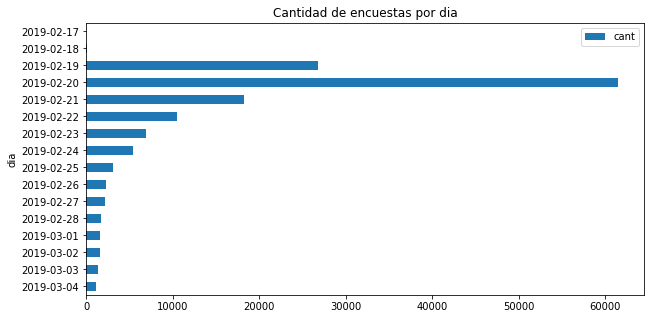

In [55]:
by_day.plot.barh(x='dia',y='cant',title='Cantidad de encuestas por dia')

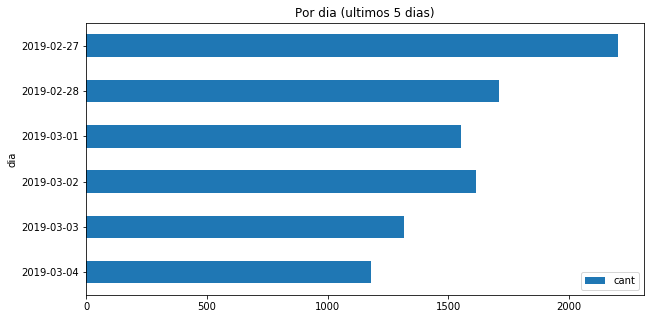

In [56]:
d = datetime.datetime.now() - datetime.timedelta(days=6)
by_day = by_day[by_day['dia'] > d.strftime("%Y-%m-%d")]
by_day.plot.barh(x='dia',y='cant',title='Por dia (ultimos 5 dias)')

In [57]:
by_candidate = df[['nombre','fecha']]
by_candidate["dia"] = by_candidate.fecha.apply(lambda x: x[0:10])
by_candidate.drop(columns=['fecha'],inplace=True)
by_candidate.head(10)
#TODO aca me gustaria hacer unas graficas por dia por candidato

,nombre,dia
0,Edgardo Novick,2019-02-07
1,Luis Lacalle Pou,2019-02-19
2,Carolina Cosse,2019-02-21
3,Daniel Martínez,2019-02-21
4,Luis Lacalle Pou,2019-02-21
5,Carolina Cosse,2019-02-21
6,Julio María Sanguinetti,2019-02-21
7,Ernesto Talvi,2019-02-21
8,Ernesto Talvi,2019-02-19
9,Luis Lacalle Pou,2019-02-21


# Entrenamiento de modelo

In [58]:
df.head()

,Unnamed: 0,id,1,10,11,12,13,14,15,16,...,4,5,6,7,8,9,candidatoId,fecha,partido,nombre
0,0,100,2,4,2,2,5,3,4,4,...,4,2,5,4,4,4,20,2019-02-07T18:17:25.611401,Partido de la Gente,Edgardo Novick
1,1,1000,2,3,3,3,4,3,4,3,...,3,3,5,5,4,4,9,2019-02-19T16:54:35.074392,Partido Nacional,Luis Lacalle Pou
2,2,100001,4,5,5,5,5,1,1,3,...,1,5,1,1,4,5,3,2019-02-21T15:56:04.223884,Frente Amplio,Carolina Cosse
3,3,100006,4,1,5,1,5,5,5,4,...,5,5,5,5,2,4,4,2019-02-21T15:56:21.236512,Frente Amplio,Daniel Martínez
4,4,100011,5,5,2,5,4,5,4,5,...,4,1,5,4,4,4,9,2019-02-21T15:56:46.090402,Partido Nacional,Luis Lacalle Pou


In [70]:
features = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7',
       '8', '9']

In [73]:
def add_total(row, features):
    total = 0
    for i in features:
        total += row[i]
    return total

df['suma_respuestas'] = df.apply(lambda row: add_total(row, features),axis=1)

In [80]:
todo_5 = len(df[df['suma_respuestas'] == 26*5])
todo_3 = len(df[df['suma_respuestas'] == 26*3])
todo_1 = len(df[df['suma_respuestas'] == 26])
print('cant encuestas todo 5: {}'.format(todo_5))
print('cant encuestas todo 1: {}'.format(todo_1))

cant encuestas todo 5: 63
cant encuestas todo 1: 89


In [81]:
#TODO conviene sacar las todo 5 y todo 1 ?

# LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression

#Split train and test
df_train, df_test = train_test_split(df, test_size=0.20)

In [35]:
# Try to predict candidate
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=700).fit(df_train[features], df_train.candidatoId)
df_test['predicted_candidate'] = clf.predict(df_test[features])

df_test['predicted_candidate'] = df_test['predicted_candidate'].apply(get_name)
df_test['candidato'] = df_test['candidatoId'].apply(get_name)


In [37]:
print(classification_report(df_test.nombre,df_test.predicted_candidate))

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.00      0.00      0.00        25
            Carlos Techera       0.00      0.00      0.00         1
            Carolina Cosse       0.39      0.42      0.40       738
                César Vega       0.24      0.04      0.07       116
           Daniel Martínez       0.37      0.62      0.46       915
Edgardo Martínez Zimarioff       0.00      0.00      0.00         2
            Edgardo Novick       0.00      0.00      0.00       215
             Enrique Antía       0.00      0.00      0.00        46
             Ernesto Talvi       0.37      0.62      0.46       977
            Gonzalo Abella       0.32      0.09      0.15        74
             Gustavo Salle       0.00      0.00      0.00        33
             Héctor Rovira       0.00      0.00      0.00         2
           Jorge Larrañaga       0.20      0.00      0.01       229
        José Amorín Batlle       0.00      0.00

### este pareceria ser el mejor de los 3, lo ponemos en prod?

# El modelo original (en produccion)

In [89]:
df_original = df[df.id < 206]

In [90]:
len(df_original)

177

In [111]:
n=17
k=7

#entreno con el df original y testeo con el resto de los datos

pca = PCA(n_components=n)
pca.fit(df_original[features])
x_train = pca.transform(df_original[features])
y_train = df_original.candidatoId
x_test = pca.transform(df[df.id>=206][features])
y_test = df[df.id>=206].candidatoId

candidate_model = KNeighborsClassifier(n_neighbors=n)
candidate_model.fit(x_train, y_train)
results = pd.DataFrame()
results['truth'] = y_test
results['truth'] = results.truth.apply(get_name)
results['prediction'] = candidate_model.predict(x_test)
results['prediction'] = results.prediction.apply(get_name)

print(classification_report(results.truth,results.prediction ))

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.00      0.00      0.00       109
            Carlos Techera       0.00      0.00      0.00        12
            Carolina Cosse       0.26      0.38      0.31      3759
                César Vega       0.05      0.00      0.01       588
           Daniel Martínez       0.35      0.64      0.45      4806
Edgardo Martínez Zimarioff       0.00      0.00      0.00        24
            Edgardo Novick       0.10      0.03      0.05      1092
             Enrique Antía       0.00      0.00      0.00       235
             Ernesto Talvi       0.31      0.58      0.40      5127
            Gonzalo Abella       0.00      0.00      0.00       409
             Gustavo Salle       0.00      0.00      0.00       201
             Héctor Rovira       0.00      0.00      0.00        39
           Jorge Larrañaga       0.00      0.00      0.00      1241
        José Amorín Batlle       0.00      0.00

# Ahora probamos un nuevo KNeighborsClassifier

In [112]:
n=22
k=22

pca = PCA(n_components=n)
pca.fit(df[features])
X = pca.transform(df[features])
y = df.candidatoId

#entreno con el 80% de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
candidate_model = KNeighborsClassifier(n_neighbors=n)
candidate_model.fit(X_train, y_train)
results = pd.DataFrame()
results['truth'] = y_test
results['truth'] = results.truth.apply(get_name)
results['prediction'] = candidate_model.predict(X_test)
results['prediction'] = results.prediction.apply(get_name)

print(classification_report(results.truth,results.prediction ))

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.50      0.05      0.09        21
            Carlos Techera       0.00      0.00      0.00         2
            Carolina Cosse       0.37      0.39      0.38       769
                César Vega       0.00      0.00      0.00       122
           Daniel Martínez       0.37      0.54      0.44       947
Edgardo Martínez Zimarioff       0.00      0.00      0.00         7
            Edgardo Novick       0.05      0.01      0.02       217
             Enrique Antía       0.00      0.00      0.00        37
             Ernesto Talvi       0.32      0.54      0.40      1035
            Gonzalo Abella       0.50      0.03      0.06        88
             Gustavo Salle       0.00      0.00      0.00        36
             Héctor Rovira       0.00      0.00      0.00         8
           Jorge Larrañaga       0.07      0.00      0.01       244
        José Amorín Batlle       0.00      0.00

### Gana el LR